## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.metrics import mean_squared_error

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [95]:
df = df.resample('1H').sum()
decomposed = seasonal_decompose(df)
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [97]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Проверим на монотонность

In [98]:
df.index.is_monotonic

True

## 1 Вывод
Данные чистые, никакие предобработки не нужны

# 2. Анализ

Добавим столбцы (год, месяц и т.д.) и взглянем на графики

In [99]:
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

make_features(df)
df.head()

,num_orders,year,month,day,hour,dayofweek
datetime,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3
2018-03-01 01:00:00,85,2018,3,1,1,3
2018-03-01 02:00:00,71,2018,3,1,2,3
2018-03-01 03:00:00,66,2018,3,1,3,3
2018-03-01 04:00:00,43,2018,3,1,4,3


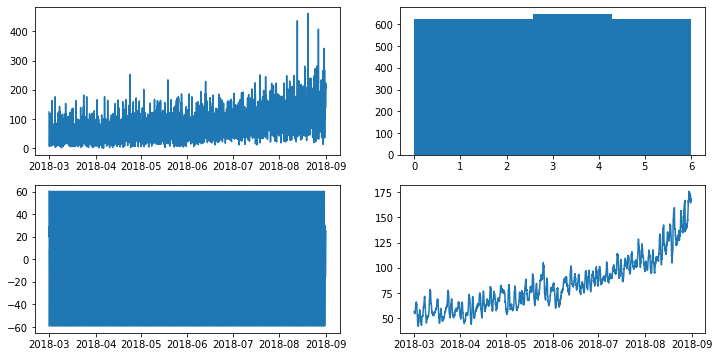

In [100]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(12)
_ = ax1.plot(df['num_orders'])
_ = ax2.hist(df['dayofweek'], bins=7)
_ = ax3.plot(decomposed.seasonal)
_ = ax4.plot(decomposed.trend)

Детальнее взглянем на сезонность

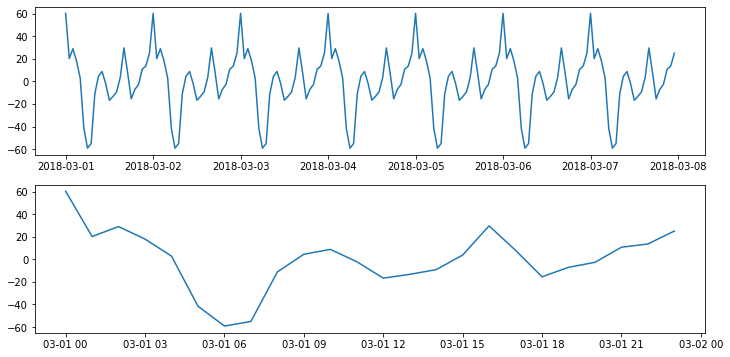

In [101]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(6)
fig.set_figwidth(12)
_ = ax1.plot(decomposed.seasonal['2018-03-01':'2018-03-07'])
_ = ax2.plot(decomposed.seasonal['2018-03-01'])


In [112]:
df['month'].value_counts()

7    744
3    744
5    744
8    744
6    720
4    720
Name: month, dtype: int64

## 2 Вывод
- По четвергам и пятница заказов немного больше остальных дней
- Пиковые часы: начало и конец рабочего дня, также около полуночи

# 3. Обучение

In [104]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Линейная регрессия

In [105]:
model_ln = LinearRegression()
model_ln.fit(train.drop('num_orders', axis=1), train['num_orders'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Дерево решений

In [106]:
model_dtr = DecisionTreeRegressor(max_depth=20, random_state=42)
model_dtr.fit(train.drop('num_orders', axis=1), train['num_orders'])

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Случайный лес

In [107]:
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=12)
model_rfr.fit(train.drop('num_orders', axis=1), train['num_orders'])


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12, verbose=0,
                      warm_start=False)

# 4. Тестирование

Линейная регрессия

In [108]:
train_predict = model_ln.predict(train.drop('num_orders', axis=1))
test_predict = model_ln.predict(test.drop('num_orders', axis=1))
print("RMSE обучающей выборки:", mean_squared_error(train['num_orders'], train_predict)**(1/2))
print("RMSE тестовой выборки: ", mean_squared_error(test['num_orders'], test_predict)**(1/2))

RMSE обучающей выборки: 34.43111380550365
RMSE тестовой выборки:  63.78900123113787


Дерево решений

In [109]:
train_predict = model_dtr.predict(train.drop('num_orders', axis=1))
test_predict = model_dtr.predict(test.drop('num_orders', axis=1))
print("RMSE обучающей выборки:", mean_squared_error(train['num_orders'], train_predict)**(1/2))
print("RMSE тестовой выборки: ", mean_squared_error(test['num_orders'], test_predict)**(1/2))

RMSE обучающей выборки: 1.41525557084824
RMSE тестовой выборки:  46.66052669153255


Случайный лес

In [110]:
train_predict = model_rfr.predict(train.drop('num_orders', axis=1))
test_predict = model_rfr.predict(test.drop('num_orders', axis=1))
print("RMSE обучающей выборки:", mean_squared_error(train['num_orders'], train_predict)**(1/2))
print("RMSE тестовой выборки: ", mean_squared_error(test['num_orders'], test_predict)**(1/2))

RMSE обучающей выборки: 20.308038195145986
RMSE тестовой выборки:  48.88474800284499


# Вывод
Лучшей моделью выберем Дерево решений со значением RMSE = 47